In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# 1. Load the dataset

In [11]:
# Load the dataset
df = pd.read_csv('/kaggle/input/mydataset1/filtered_attacks (1).csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 2. Feature Engineering: Creating new specific features

In [12]:

# 1. Feature Engineering: Creating new specific features
# These features are designed to capture differences in protocol behavior and traffic flow
df['Fwd_Bwd_Pkts_Ratio'] = df['Total Fwd Packets'] / (df['Total Backward Packets'] + 1)
df['Total_Bytes'] = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']
df['Header_to_Data_Ratio'] = (df['Fwd Header Length'] + df['Bwd Header Length']) / (df['Total_Bytes'] + 1)
df['Bwd_to_Fwd_Bytes_Ratio'] = df['Total Length of Bwd Packets'] / (df['Total Length of Fwd Packets'] + 1)
df['Flow_IAT_Range'] = df['Flow IAT Max'] - df['Flow IAT Min']
df['Avg_IAT'] = df['Flow Duration'] / (df['Total Fwd Packets'] + df['Total Backward Packets'] + 1)
df['Packet_Size_Spread'] = df['Max Packet Length'] - df['Min Packet Length']

# 2. Preparation for Evaluation
# Dropping duplicates and balancing for a fair assessment
df_clean = df.drop_duplicates(subset=[c for c in df.columns if c != 'Label'])
df_balanced = df_clean.groupby('Label').apply(lambda x: x.sample(n=min(len(x), 1900), random_state=42)).reset_index(drop=True)

X = df_balanced.drop(columns=['Label'])
if 'Destination Port' in X.columns:
    X = X.drop(columns=['Destination Port'])
y = df_balanced['Label']

# 3. Check Importance of New Features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

new_features = ['Fwd_Bwd_Pkts_Ratio', 'Total_Bytes', 'Header_to_Data_Ratio', 'Bwd_to_Fwd_Bytes_Ratio', 'Flow_IAT_Range', 'Avg_IAT', 'Packet_Size_Spread']
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Importance of newly engineered features:")
print(importances[new_features].sort_values(ascending=False))

# 4. Clustering with Engineered Features
# Use PowerTransformer on the full set of features (including new ones)
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pt.fit_transform(X)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_transformed)

/tmp/ipykernel_55/2042232955.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_clean.groupby('Label').apply(lambda x: x.sample(n=min(len(x), 1900), random_state=42)).reset_index(drop=True)


Importance of newly engineered features:
Total_Bytes               0.028664
Header_to_Data_Ratio      0.024856
Bwd_to_Fwd_Bytes_Ratio    0.024610
Avg_IAT                   0.021237
Fwd_Bwd_Pkts_Ratio        0.014688
Flow_IAT_Range            0.013044
Packet_Size_Spread        0.012644
dtype: float64



# Agglomerative Hierarchical Clustering:

Agglomerative Clustering Purity:
   Cluster   Dominant Attack  Purity (%)  Total Samples
0        0              DDoS       35.82           1957
1        1            BENIGN       54.34           1693
2        2       FTP-Patator       39.29           1624
3        3          DoS Hulk       43.84           2840
4        4     DoS slowloris       60.56           1174
5        5  DoS Slowhttptest       99.39            989
6        6       SSH-Patator       35.27           2807
7        7     DoS slowloris       51.87           1099
8        8          PortScan       98.69           1911
9        9              DDoS       51.89           1644


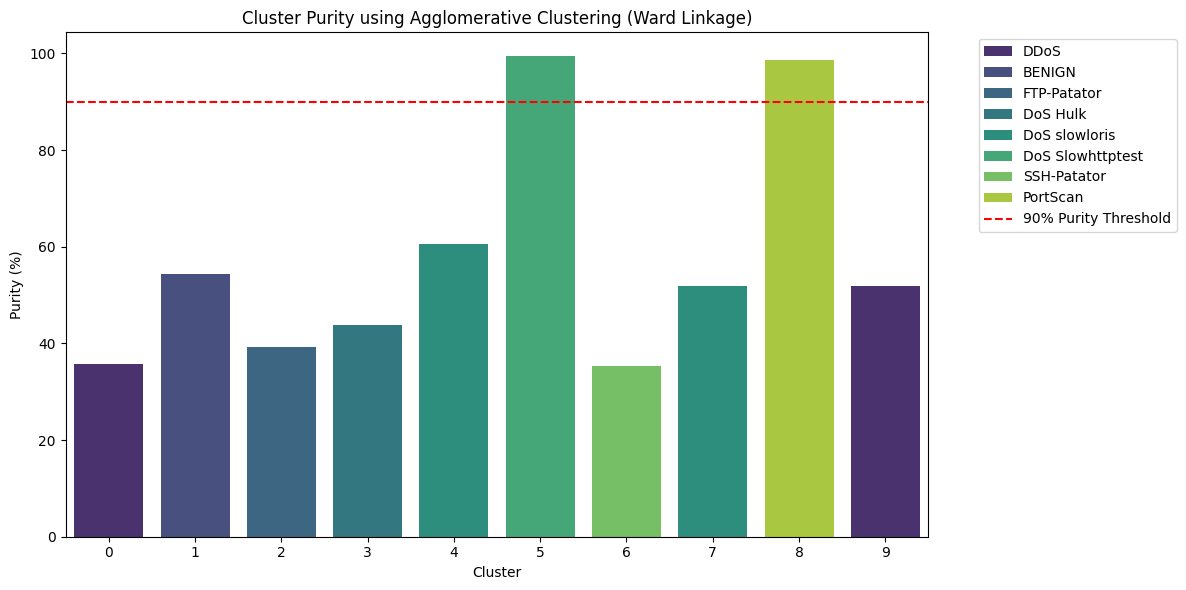

In [15]:
from sklearn.cluster import AgglomerativeClustering
n_components = 10
# Trying Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_components, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

df_balanced['Agg_Cluster'] = agg_labels

# Calculate Purity for Agglomerative
agg_purity = pd.crosstab(df_balanced['Agg_Cluster'], df_balanced['Label'])
agg_purity_stats = []
for cluster in range(n_components):
    cluster_data = agg_purity.loc[cluster]
    dominant_attack = cluster_data.idxmax()
    dominant_count = cluster_data.max()
    total_in_cluster = cluster_data.sum()
    purity = (dominant_count / total_in_cluster) * 100
    agg_purity_stats.append({
        'Cluster': cluster,
        'Dominant Attack': dominant_attack,
        'Purity (%)': round(purity, 2),
        'Total Samples': total_in_cluster
    })

agg_purity_df = pd.DataFrame(agg_purity_stats)
print("Agglomerative Clustering Purity:")
print(agg_purity_df)

# Let's try to visualize this for the user
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Purity (%)', hue='Dominant Attack', data=agg_purity_df, palette='viridis')
plt.title('Cluster Purity using Agglomerative Clustering (Ward Linkage)')
plt.axhline(y=90, color='r', linestyle='--', label='90% Purity Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('agg_purity_analysis.png')